In [1]:
from brian2 import *
%matplotlib inline
import numpy as np
import pytime

In [2]:
tau = 5*ms
N1 = 9**2
N2 = int(np.sqrt(N1))
I0 = 100*0.3*volt/second

eqsL1='''
dv/dt = I : volt
I : volt/second
'''

eqsL2 ='''
dv/dt = -v/tau : volt (unless refractory)
'''

In [3]:
L1 = NeuronGroup(N1, eqsL1, threshold='v>0.3*volt', reset='v = 0*volt', method='euler')
L2 = NeuronGroup(N2, eqsL2, threshold='v>0.3*volt', reset='v = 0*volt', refractory=5*ms, method='euler')

tmp = np.array([[-1/6, -1/6, 1/3],
                [-1/6, 1/3, -1/6],
                [1/3, -1/6, -1/6]])

W = np.zeros([N1,N2])
count=0
for a in [0,3,6]:
    for b in [0,3,6]:
        W_tmp = np.zeros([N2,N2])
        W_tmp[0+a:3+a,0+b:3+b] = tmp
        W[:,count] = W_tmp.flatten()
        count+=1
#imshow(W,cmap='RdYlGn')
#colorbar()

S = Synapses(L1, L2, 'w : volt', on_pre='v += w')
S.connect()
S.w[:] = W.flatten()*0.3*volt

WARNING    Cannot use Cython, a test compilation failed: Microsoft Visual C++ 14.0 or greater is required. Get it with "Microsoft C++ Build Tools": https://visualstudio.microsoft.com/visual-cpp-build-tools/ (DistutilsPlatformError) [brian2.codegen.runtime.cython_rt.cython_rt.failed_compile_test]
INFO       Cannot use compiled code, falling back to the numpy code generation target. Note that this will likely be slower than using compiled code. Set the code generation to numpy manually to avoid this message:
prefs.codegen.target = "numpy" [brian2.devices.device.codegen_fallback]


In [4]:
stMonL1 = StateMonitor(L1,'v', record=True)
stMonL2 = StateMonitor(L2,'v', record=True)
spMonL1 = SpikeMonitor(L1)
spMonL2 = SpikeMonitor(L2)

In [5]:
for t in range(9):
    tmp = np.zeros(N1)
    for t2 in range(t+1):
        tmp[t+t2*8] = 1
    L1.I = I0*tmp
    run(100*ms)
    
for t in range(8):
    tmp = np.zeros(N1)
    for t2 in range(8-t):
        tmp[t*9+t2*8+17] = 1
    L1.I = I0*tmp
    run(100*ms)

Text(0, 0.5, 'v')

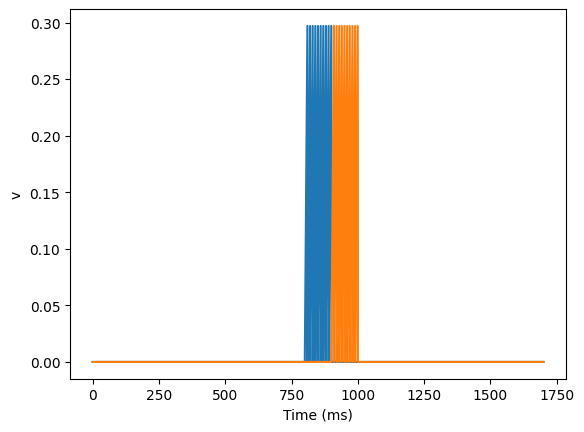

In [8]:
plot(stMonL1.t/ms, stMonL1.v[8])
plot(stMonL1.t/ms, stMonL1.v[73])
xlabel('Time (ms)')
ylabel('v')

Text(0, 0.5, 'Neuron index')

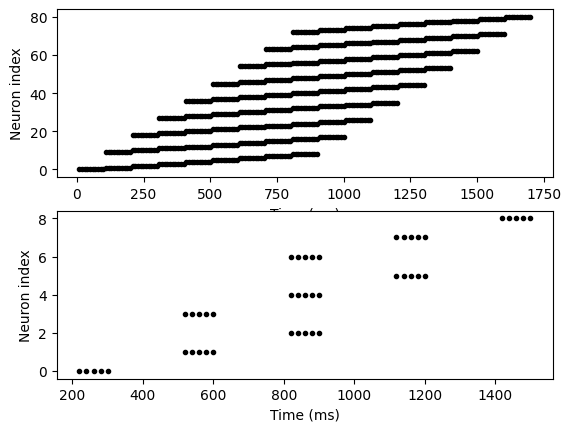

In [9]:
subplot(211)
plot(spMonL1.t/ms, spMonL1.i, '.k')
xlabel('Time (ms)')
ylabel('Neuron index')

subplot(212)
plot(spMonL2.t/ms, spMonL2.i, '.k')
xlabel('Time (ms)')
ylabel('Neuron index')

In [ ]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyper-parameters 
input_size = 784 # 28x28
hidden_size = 500 
num_classes = 10
num_epochs = 2
batch_size = 100
learning_rate = 0.001

# MNIST dataset 
train_dataset = torchvision.datasets.MNIST(root='./data', 
                                           train=True, 
                                           transform=transforms.ToTensor(),  
                                           download=True)

test_dataset = torchvision.datasets.MNIST(root='./data', 
                                          train=False, 
                                          transform=transforms.ToTensor())

# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)

examples = iter(test_loader)
example_data, example_targets = next(examples)

for i in range(6):
    plt.subplot(2,3,i+1)
    plt.imshow(example_data[i][0], cmap='gray')
plt.show()

# Fully connected neural network with one hidden layer
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNet, self).__init__()
        self.input_size = input_size
        self.l1 = nn.Linear(input_size, hidden_size) 
        self.relu = nn.ReLU()
        self.l2 = nn.Linear(hidden_size, num_classes)  
    
    def forward(self, x):
        out = self.l1(x)
        out = self.relu(out)
        out = self.l2(out)
        # no activation and no softmax at the end
        return out

model = NeuralNet(input_size, hidden_size, num_classes).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)  

# Train the model
n_total_steps = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):  
        # origin shape: [100, 1, 28, 28]
        # resized: [100, 784]
        images = images.reshape(-1, 28*28).to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 100 == 0:
            print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')

# Test the model
# In test phase, we don't need to compute gradients (for memory efficiency)
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    for images, labels in test_loader:
        images = images.reshape(-1, 28*28).to(device)
        labels = labels.to(device)
        outputs = model(images)
        # max returns (value ,index)
        _, predicted = torch.max(outputs.data, 1)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()

    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network on the 10000 test images: {acc} %')